**@NuttidaLab: Tutorial on Bayesian Modeling**\
Date: 20th November 2024\
Author: Rudra

## 1. Refresher on Probabilities

In [1]:
# @utility
# Math imports
import math
import numpy as np
from scipy.stats import norm, poisson, expon, uniform, binom, beta, halfnorm

# Data imports
import pandas as pd

# Model imports
from cmdstanpy import CmdStanModel
import tempfile

# Plotting imports
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import arviz as az

### 1.1 Probability and Quantifying Variability

Probability is defined as a number between 0 and 1, which describes the likelihood of the occurrence of some particular event in some range of events. 0 means an infinitely unlikely event, and 1 means the certain event. The term ‘event’ is very general, but for us can usually be thought of as one sample data point in an experiment, and the ‘range of events’ would be all the data we would get if we sampled virtually an infinite dataset on the experiment. For now, We are only interested in quantifying the sample variability. [ref](https://geofaculty.uwyo.edu/neil/teaching/Numerical_web/Yaxis_values.pdf)

Imagine a bag with red and blue balls as such:

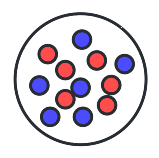

6 red balls and 6 blue balls.


If you randomly "sample" one ball (a.k.a. event), the probability of getting a red ball is the fraction of red balls to the total.

$$
P(Red)= \frac {\text{Number of Red Balls}​} {\text{Total Number of Balls}}\\
$$

Similarly, the probability of getting a blue ball is the fraction of blue balls to the total.
$$
P(Blue)= \frac {\text{Number of Blue Balls}​} {\text{Total Number of Balls}}\\
$$

And the sum of the probabilities of all possible outcomes would be 1.
$$
P(Red) + P(Blue) = 1
$$

If you sampled a ball and put it back in the bag, the probability of getting a red ball would be the same on the next draw.\
However, if you sampled a ball and didn't put it back in the bag, the probability of getting a red ball would change for the next draw. (It would be less than previous event)\
This is because the sample space has changed (we wont go too much into this for now).

**For the rest of this tutorial, we will assume that the generative process that makes these balls can infinitly keep making balls and we can draw as much as we want to discover the true distribution.**\
If you sampled a ball and put it back in the bag, that is your generative process.\
In this manner, if you repeatedly sample from the bag, there is no limit to the number balls you could draw.\
With sufficient draws you can be more and more confident about the vraiability in the probability and the true distribution in the generative process.\
With a large dataset, the sample probability will converge to the true probability which sould be .5/.5 in this case.

***Run the code cell below multiple times and see which graph changes most dramatically between runs***

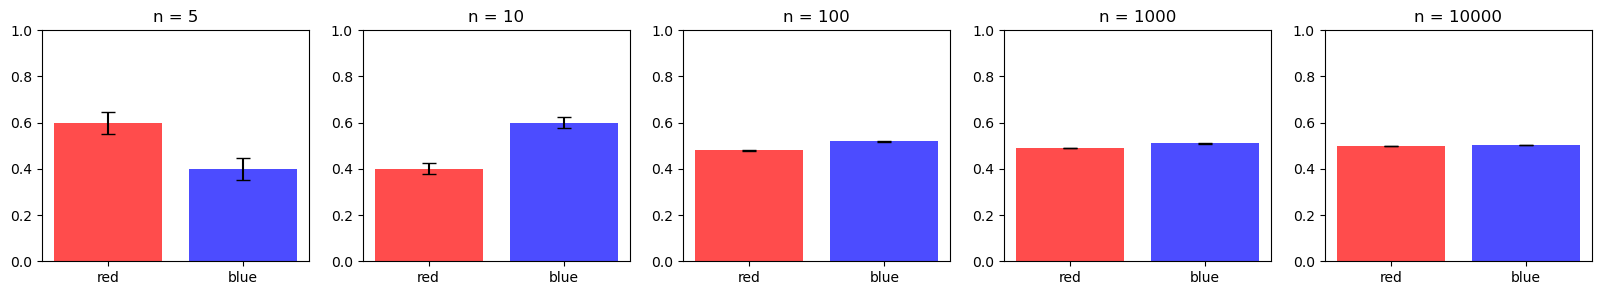

In [2]:
# @utility
# show the probabiltity converging to .5 .5 with increasing number of samples from a np.random.choice(["red", "blue"])
n_draws = [5, 10, 100, 1000, 10000]
color=["#ff4c4c", "#4c4cff"]

# bar graphs for each n_draws with the variance of the probability (error bars)
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
for i, n in enumerate(n_draws):
    data = np.random.choice(["red", "blue"], n)
    p = np.mean(data == "red")
    var = p * (1 - p) / n
    ax[i].bar(["red", "blue"], [p, 1 - p], color=color)
    ax[i].errorbar(["red", "blue"], [p, 1 - p], yerr=var, fmt="none", ecolor="black", capsize=5)
    ax[i].set_title(f"n = {n}")
    ax[i].set_ylim(0, 1)

### 1.2 Updating beliefs with new data

As you intuitively understood from above experiment, as you draw more and more samples, you can be more and more confident about the true distribution of the balls in the bag.\
This is the **basis of Bayesian statistics**.

We can formalize this process with Bayes' theorem:

$$
P(\text{Red | Data}) = \frac{P(\text{Data | Red}) P(\text{Red})}{P(\text{Data})}
$$
Where:
- $ P(\text{Red}) $: Prior belief about the proportion of red balls.
- $ P(\text{Data | Red}) $: Likelihood of observing the data given the proportion of red balls.
- $ P(\text{Data}) $: Total probability of observing the data.

So, basically, as you you aquired more data, you updated your belief about the proportion of red balls in the bag. (which in this case is the same as the probability)

### 1.3 Discrete to Continuous space

**Notice** how you could either get a red ball or either a blue ball. This means your **choices are discrete.**

Sometimes, it is possible that the generative process is **continuous**.\
Such as, what if the bag had balls in a **spectrum of colors** between red and blue and till now you were only sampling from a specific subset of the dataset. And now for some unknown reason, the generative process has changed and you are now sampling from the whole dataset.\
As such:

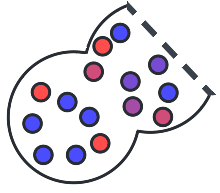


To discover this new true distribution of the generative process, we make histograms of the samples we draw.\
By making the buckets in the histograms thinner and thinner (to infinity), we can get a better idea of the ***true continuous distribution***.

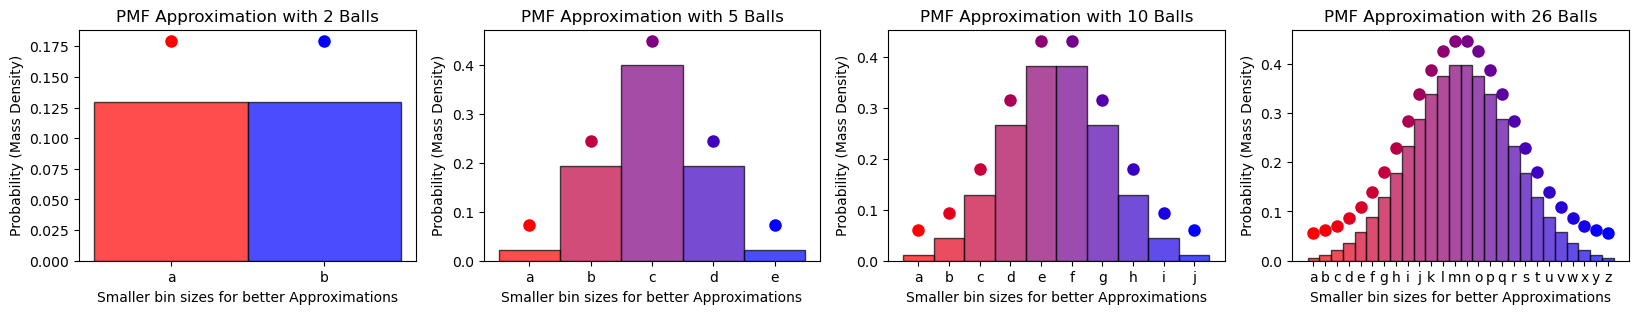

In [3]:
# @Utility

# Define colors for red and blue gradient
def get_color_gradient(n, color1="red", color2="blue"):
    cmap = mcolors.LinearSegmentedColormap.from_list("gradient", [color1, color2])
    return [cmap(i / (n - 1)) for i in range(n)]

# Normal distribution parameters
mu, sigma = 0, 1
# Prepare the plot
num_bins_list = [2, 5, 10, 26]  # Number of discrete approximations

# Function to create PMF approximation
def create_pmf(num_bins, mu, sigma):
    bins = np.linspace(-3, 3, num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    pmf_values = norm.pdf(bin_centers, mu, sigma)
    return bins, bin_centers, pmf_values

def plot_approximation(num_bins_list, mu, sigma):
    fig, axes = plt.subplots(1, len(num_bins_list), figsize=(20, 3), sharex=False)
    for ax, num_bins in zip(axes, num_bins_list):
        bins, bin_centers, pmf_values = create_pmf(num_bins, mu, sigma)
        gradient_colors = get_color_gradient(num_bins, color1="red", color2="blue")

        # Plot bars and assign colors
        ax.bar(bin_centers, pmf_values, width=(bins[1] - bins[0]), color=gradient_colors, edgecolor='black', alpha=0.7)

        # Plot balls as dots above the bars
        for center, value, color in zip(bin_centers, pmf_values, gradient_colors):
            ax.plot(center, value + 0.05, 'o', color=color, markersize=8)

        # Label and title
        ax.set_title(f"PMF Approximation with {num_bins} Balls")
        ax.set_ylabel("Probability (Mass Density)")
        ax.set_xticks(bin_centers)
        ax.set_xticklabels([f"{chr(97 + i)}" for i in range(num_bins)])
        ax.set_xlabel("Smaller bin sizes for better Approximations")

    plt.show()

plot_approximation(num_bins_list, mu, sigma)

Transitioning from a discrete probability to a continuous probability involves shifting from assigning probabilities to distinct, separate outcomes to describing probabilities across a continuum of possibilities.\
Additionally, what if the underlying generative process has **changed the odds** of getting different colors of balls?\
for example:

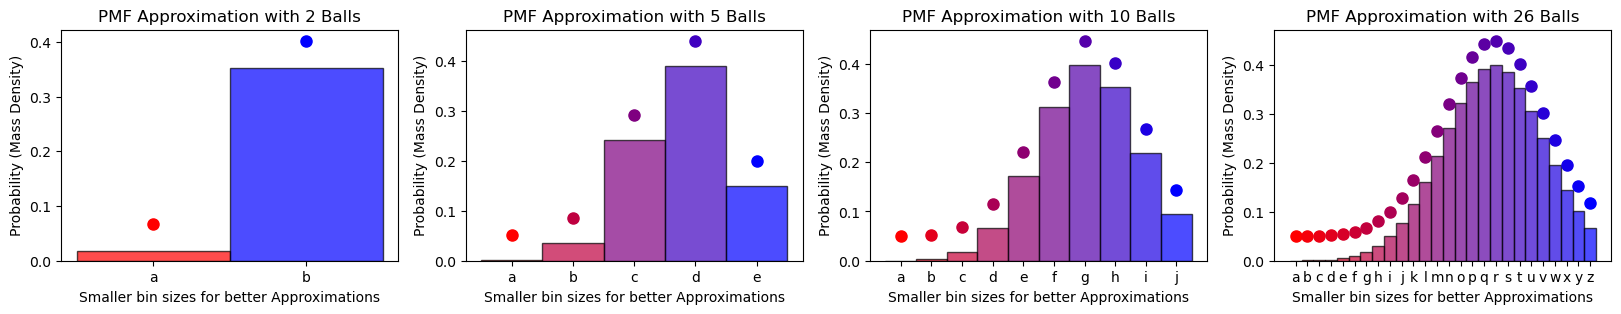

In [4]:
# Normal distribution parameters
mu, sigma = 1, 1
num_bins_list = [2, 5, 10, 26]  # Number of discrete approximations
plot_approximation(num_bins_list, mu, sigma)

**We need a way to model this continuous distribution!**\
To do this, we assume that the histogram is an approximation of a continuous function which describes a probability distribution.\
And we map our histogram to the "best suited" continuous function hoping that this is the true distribution of the generative process.

Below are some examples of different continuous functions that can be used to approximate the histogram:

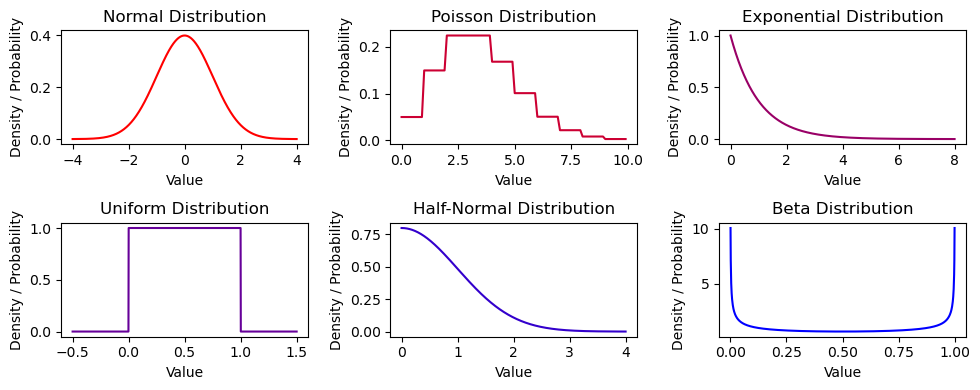

In [5]:
# @Utility

x_values = {
    "Normal": np.linspace(-4, 4, 1000),
    "Poisson": np.arange(0, 10, 0.1),  # Approximation for visualization
    "Exponential": np.linspace(0, 8, 1000),
    "Uniform": np.linspace(-0.5, 1.5, 1000),  # Extending slightly beyond range for visualization
    # "Binomial": np.arange(0, 11),  # Discrete values for visualization
    "Half-Normal": np.linspace(0, 4, 1000),
    "Beta": np.linspace(0, 1, 1000),
}

# Corresponding probability density/mass functions
pdfs = {
    "Normal": norm.pdf(x_values["Normal"], loc=0, scale=1),
    "Poisson": poisson.pmf(x_values["Poisson"].astype(int), mu=3),
    "Exponential": expon.pdf(x_values["Exponential"], scale=1),
    "Uniform": uniform.pdf(x_values["Uniform"], loc=0, scale=1),
    # "Binomial": binom.pmf(x_values["Binomial"], n=10, p=0.5),
    "Half-Normal": halfnorm.pdf(x_values["Half-Normal"]),
    "Beta": beta.pdf(x_values["Beta"], a=.5, b=.5),
}

# Plotting continuous lines
plt.figure(figsize=(10, 4))
colors = get_color_gradient(len(pdfs))

for i, (dist_name, x_vals) in enumerate(x_values.items()):
    plt.subplot(2, 3, i + 1)
    plt.plot(x_vals, pdfs[dist_name], color=colors[i], label=f"{dist_name} PDF/PMF")
    plt.title(f"{dist_name} Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density / Probability")

plt.tight_layout()
plt.show()


***So which function should we choose?***

## 2. Bayesian Thinking

### 2.1 Probality Interpretation

Choosing the right distribution is a question of what fits the data best.\
And **when we are aproximating the data, we are fitting a model!**

There are 2 schools of thought on this:  
1. **Frequentist**: They consider the data as fixed (given the experiment) and view the model parameters as unknown but fixed quantities. They use methods like Maximum Likelihood Estimation (MLE) to estimate the parameters that maximize the likelihood of observing the data.

2. **Bayesian**: They consider the data as observed, and the **model parameters as random variables with prior beliefs**. They use **Bayes' theorem to update their prior beliefs** about the parameters into posterior distributions based on the observed data.

**For the purpose of this tutorial, we will focus specifically on the Bayesian approach.**

### 2.2 Bayesian Model Specification

**Bayesian model specification involves 3 components:**

1. **Prior**: The prior distribution describes the beliefs about the model parameters before observing the data. It is often assumed to be a normal distribution.
2. **Likelihood**: The likelihood function describes the probability of observing the data given the model parameters. It is the foundation of the model.
3. **Posterior**: The posterior distribution describes the updated beliefs about the model parameters after observing the data. It is calculated using Bayes' theorem.

We can update our beliefs about the generative process by using the posterior distribution:
$$Posterior = \frac{Likelihood \times Prior}{Evidence}$$


**For our example of the balls in the bag, we can specify the model as follows:**

**Prior**:
 
$$\mu \sim \mathcal{N}(0, 1)$$ 
$$\sigma \sim |\mathcal{N}(0, 1)|$$

**Likelihood**:
$$y \sim \mathcal{N}( \mu, \sigma^2)$$


**Posterior**:
$$P(\mu, \sigma | y) = \frac{P(y | \mu, \sigma) P(\mu) P(\sigma)}{P(y)}$$

**Where**:
- $y$ is the data (balls drawn from the bag).
- $\mu$ is the mean of the distribution.
- $\sigma$ is the standard deviation of the distribution.
- $\mathcal{N}$ is the normal distribution.


### 2.3 Inference

Yayy, now that we have everything, *LETS GO AND SOLVE IT!!!!*\
But wait, how do we solve it?

Solving means calculating the posterior distribution $P(\mu, \sigma | y)$.

- **Analytically**:\
We can solve the posterior distribution analytically for simple models such as this.
- **Numerically**:\
For complex models, it is often **intractable to solve** the posterior distribution analytically. In such cases, we can use numerical methods like **Markov Chain Monte Carlo (MCMC)** or **Variational Inference (VI)** to approximate the posterior distribution.

**For the purpose of this tutorial, we will use MCMC to approximate the posterior distribution.**

In [6]:
#@utility
# Define the Stan model
model_specification = """
data {
    int<lower=0> N;
    array[N] real y;
}
parameters {
    real mu;
    real<lower=0> sigma;
}
model {
    // Priors
    mu ~ normal(0, 1);
    sigma ~ normal(0, 1);

    // Likelihood
    y ~ normal(mu, sigma);
}
"""
# Write the model string to a temporary file
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as tmp_file:
    tmp_file.write(model_specification)
    tmp_stan_path = tmp_file.name

# Prepare the unknown generator data
data = {
    "N": 1000,
    "y": np.random.normal(loc=1, scale=1, size=1000),
}

# Compile and fit the model
model = CmdStanModel(stan_file=tmp_stan_path)
fit = model.sample(data=data, iter_sampling=1000, step_size=0.1)

13:19:49 - cmdstanpy - INFO - compiling stan file /tmp/tmpsyz10iw1.stan to exe file /tmp/tmpsyz10iw1
13:19:53 - cmdstanpy - INFO - compiled model executable: /tmp/tmpsyz10iw1
13:19:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:19:53 - cmdstanpy - INFO - CmdStan done processing.


Now that we have approximated the posterior distribution and updated the prior beliefs.\
We can take a look at them. do they look like the true distribution of the generative process?

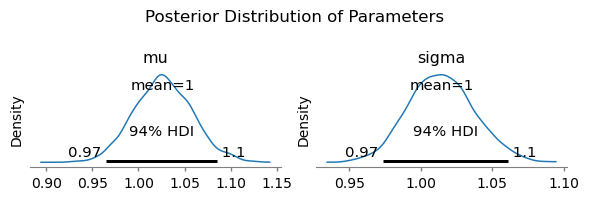

In [7]:
#@utility
idata = az.from_cmdstanpy(fit)

# Plot the posterior distribution
ax = az.plot_posterior(idata, round_to=2, figsize=(6, 2), textsize=10)
plt.suptitle("Posterior Distribution of Parameters")
for a in ax: 
    a.set_ylabel("Density")
plt.tight_layout()
plt.show()

**Notes**:
- It seems like the model has updated its prior beliefs and landed on ~1.1 for $\mu$ and ~0.9 for $\sigma$ which is very close to the true distribution of the generative process (1 $\mu$ and 1 $\sigma$).
- The model is uncertain about it's estimation only to a very small degree. The range for $\mu$ is 1 to 1.1 and for $\sigma$ is 0.95 to 1. It is essentially pretty certain about these parameters.

**Let's now visualize the fit of the model to the data.**

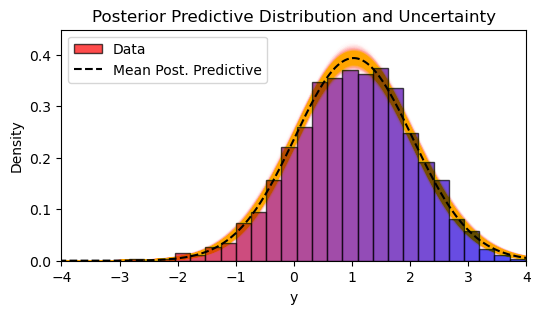

In [8]:
#@utility
num_bins = 26

all_mu = idata.posterior.mu.values.flatten()
all_sigma = idata.posterior.sigma.values.flatten()

# make linespace and make the pdf
x = np.linspace(-5, 5, 1000)

# Plot the histogram and the posterior predictive distribution
plt.figure(figsize=(6, 3))

# Plot the data used to fit the model
_, _, patches = plt.hist(data["y"], bins=num_bins, density=True, edgecolor='black', color="skyblue", alpha=0.7, label="Data")
for i in range(len(patches)): patches[i].set_facecolor(get_color_gradient(num_bins)[i])

# Plot the uncertainty in the model
for i in range(len(all_mu)):
    pdf = norm.pdf(x, loc=all_mu[i], scale=all_sigma[i])
    plt.plot(x, pdf, color="orange", alpha=0.003)

# Plot the mean of the posterior predictive distribution
mean_pdf = norm.pdf(x, loc=all_mu.mean(), scale=all_sigma.mean())
abc = plt.plot(x, mean_pdf, "k--", label="Mean Post. Predictive")

plt.legend()

plt.title("Posterior Predictive Distribution and Uncertainty")
plt.ylabel("Density")
plt.xlabel("y")
plt.xlim(-4, 4)
plt.show()

## Mixtures

In [14]:
import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
# Parameters for the mixture components
weights = [0.4, 0.35, 0.25]  # Weights for each Gaussian
means = [-2, 0, 3]           # Means of the Gaussians
std_devs = [0.8, 1, 0.5]     # Standard deviations of the Gaussians

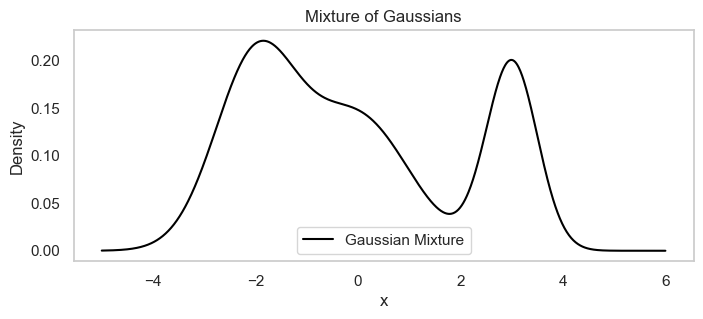

In [29]:
plt.figure(figsize=(8, 3))

# Create a range of x values
x = np.linspace(-5, 6, 1000)

# Calculate the mixture density
mixture_density = np.zeros_like(x)
for weight, mean, std in zip(weights, means, std_devs):
    mixture_density += weight * norm.pdf(x, mean, std)

# Plot the mixture
plt.plot(x, mixture_density, label="Gaussian Mixture", color="black")
plt.title("Mixture of Gaussians")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

In [ ]:
stan_code = """
data {
  int<lower=1> N;                // Number of data points
  array[N] real x;                     // Observed data
  array[K] int<lower=1> K;                // Number of mixture components
}
parameters {
  simplex[K] weights;            // Mixture weights
  array[K] real means;;                 // Means of the Gaussians
  array[K] real<lower=0> std_devs;     // Standard deviations of the Gaussians
}
model {
  for (n in 1:N) {
    vector[K] log_probs;
    for (k in 1:K) {
      log_probs[k] = log(weights[k]) + normal_lpdf(x[n] | means[k], std_devs[k]);
    }
    target += log_sum_exp(log_probs);
  }
  means ~ normal(0, 5);          // Prior for means
  std_devs ~ cauchy(0, 2);       // Prior for standard deviations
  weights ~ dirichlet(rep_vector(1, K)); // Prior for weights
}

"""

# Generate synthetic data
N = 1000
K = len(weights)

# Sample data
components = np.random.choice(K, size=N, p=weights)
x = np.array([np.random.normal(means[k], std_devs[k]) for k in components])

# Prepare data for Stan
stan_data = {
    'N': N,
    'x': x,
    'K': K,
}

# Write the model string to a temporary file
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as tmp_file:
    tmp_file.write(stan_code)
    tmp_stan_path = tmp_file.name

# Compile and fit the model
model = CmdStanModel(stan_file=tmp_stan_path)
fit = model.sample(data=stan_data, iter_sampling=1000, step_size=0.1)

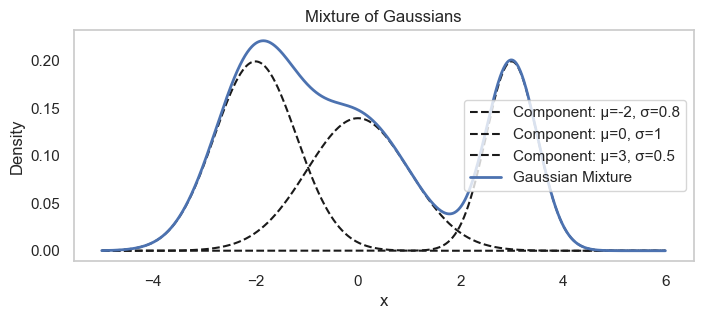

In [28]:
plt.figure(figsize=(8, 3))
# Create a range of x values
x = np.linspace(-5, 6, 1000)

# Calculate the mixture density and individual components
mixture_density = np.zeros_like(x)
for weight, mean, std in zip(weights, means, std_devs):
    component_density = weight * norm.pdf(x, mean, std)
    mixture_density += component_density
    plt.plot(x, component_density, "k--", label=f"Component: μ={mean}, σ={std}")

# Plot the mixture
plt.plot(x, mixture_density, label="Gaussian Mixture", linewidth=2)
plt.title("Mixture of Gaussians")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

## Markov Processes and Hidden Markov Models

Real-world processes produce observable outputs characterized as signals. These can be discrete or continuous
in nature, can be pure or embed uncertainty about the measurements and the explanatory model, come from
a stationary or non-stationary source, among many other variations. These signals are modeled to allow for
1
both theoretical descriptions and practical applications. The model itself can be deterministic or stochastic,
in which case the signal is characterized as a parametric random process whose parameters can be estimated
in a well-defined manner.
Many real-world signals exhibit significant autocorrelation and an extensive literature exists on different
means to characterize and model different forms of autocorrelation. One of the simplest and most intuitive is
the higher-order Markov process, which extends the “memory” of a standard Markov process beyond the
single previous observation. The higher-order Markov process, unfortunately, is not as analytically tractable
as its standard version and poses difficulties for statistical inference. A more parsimonious approach assumes
that the observed sequence is a noisy observation of an underlying hidden process represented as a first-order
Markov chain. In other terms, long-range dependencies between observations are mediated via latent variables.
It is important to note that the Markov property is only assumed for the hidden states, and the observations
are assumed conditionally independent given these latent states. While the observations may not exhibit any
Markov behavior, the simple Markovian structure of the hidden states is sufficient to allow easy inference

## 2. Input Dependency and Dynamic (Regressions)

### 2.1 Linear Regressions and Idea of Uncertainty

Traditional linear models are based on the equation:
$$
y = x \cdot w + c
$$
This form represents a **deterministic relationship** between the input $x$ and the output $y$. Every input $x$ maps to a single, exact $y$ without any randomness or uncertainty. 


In real-world data, however, outputs are often affected by factors not captured by the model (e.g., measurement errors, hidden variables, or inherent variability). Adding noise $\epsilon \sim \mathcal{N}(0, \sigma^2)$ (for example) acknowledges this uncertainty and makes the model more realistic, leading to:

$$
y = x \cdot w + c + \epsilon
$$
where:
- $x$ is the input (features),
- $w$ is the weight vector,
- $c$ is the intercept (bias),
- $\epsilon \sim \mathcal{N}(0, \sigma^2)$ is the Gaussian noise with mean $0$ and variance $\sigma^2$.

This can be equivalently **reparameterized** as:

$$
y \sim \mathcal{N}(x \cdot w + c, \sigma^2)
$$

This directly states that $y$ is drawn from a normal distribution with mean $x \cdot w + c$ and variance $\sigma^2$. (A typical Bayesian representation)

The noisy version better reflects the variability seen in observed data.

### 2.2 Model Specification for Bayesian Linear Regression
We can specify our model and its parameters as follows:

**Priors**: 
$$w \sim \mathcal{N}(0, 1)$$ 
$$c \sim \mathcal{N}(0, 1)$$
$$\sigma \sim |\mathcal{N}(0, 1)|$$
The prior distributions are initially chosen to be normal with mean $0$ and variance $1$ for simplicity.

**Likelihood**: 
$$y \sim \mathcal{N}(x \cdot w + c, \sigma^2)$$


**Posterior**:\
We will update those priors based on Bayes' theorem (above):

$$
P(w, c, \sigma | y, x) = \frac{P(y | x, w, c, \sigma) P(w) P(c) P(\sigma)}{P(y)}
$$

Where:
- $P(y | x, w, c, \sigma)$ is the likelihood of observing the data given the parameters.
- $P(w)$, $P(c)$, and $P(\sigma)$ are the prior distributions of the parameters.
- $P(y)$ is the total probability of observing the data.


In [10]:
#@utility
from cmdstanpy import CmdStanModel
import tempfile

# Define the Stan model
model_specification = """
data {
    int<lower=0> N;
    array[N] real x;
}
parameters {
    real w;
    real c;
    real<lower=0> sigma;
}
model {
    // Priors
    w ~ normal(0, 1);
    c ~ normal(0, 1);
    sigma ~ normal(0, 1);

    y ~ normal(w*x + c, sigma);
}
"""

# Write the model string to a temporary file
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as tmp_file:
    tmp_file.write(model_specification)
    tmp_stan_path = tmp_file.name

# Prepare the unknown generator data
data = {
    "N": 1000,
    "x": np.random.normal(loc=1, scale=1, size=1000),
}

# Compile the model
# model = CmdStanModel(stan_file=tmp_stan_path)